In [1]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 

In [3]:
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 

visitation_part2 = pd.read_csv('visitationdataPART2.csv') 

In [4]:
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear
0,Enfield,Dec-11,C1,Male,Standard,Dec-11,1,1992
1,Greenwich,Jun-18,A,Female,Standard,NaN,2,1972
2,Islington,Mar-18,B,Female,Standard,Oct-18,3,1985
3,Hounslow,Oct-15,C1,Female,Standard,Dec-15,4,1972
4,Barnet,May-15,C2,Male,Standard,Dec-15,5,1982


In [5]:
visitation_part1.head()

,CustomerID,visitdate,TimeofVisit,peakvisits
0,126444,2009-05-01,05:45,False
1,456610,2009-05-01,05:45,False
2,293763,2009-05-01,06:00,False
3,151253,2009-05-01,06:15,False
4,476569,2009-05-01,06:15,False


In [6]:
visitation_part2.head()

,CustomerID,visitdate,TimeofVisit,peakvisits
0,270665,2015-08-16,19:15,True
1,51641,2015-08-16,19:15,True
2,443825,2015-08-16,19:15,True
3,792203,2015-08-16,19:15,True
4,191880,2015-08-16,19:15,True


In [7]:
#not needed
#from dateutil import parser, tz
#LDN=tz.gettz("Europe/London")
#subscriptions['Join Date'] = subscriptions['Join Date'].apply(lambda x: parser.parse(x).replace(tzinfo=LDN))

In [8]:
#convert the join and end date to_date
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982


In [9]:
subscriptions.dtypes

Club                         object
Join Date            datetime64[ns]
Affluence                    object
Gender                       object
Subscription Type            object
End Date             datetime64[ns]
CustomerID                    int64
BirthYear                     int64
dtype: object

In [10]:
#set join_date as index
#subscriptions = subscriptions.set_index('Date')

In [11]:
subscriptions.describe()

,CustomerID,BirthYear
count,850033.000000,850033.000000
mean,425017.000000,1983.769095
std,245383.535021,7.966825
min,1.000000,1949.000000
25%,212509.000000,1978.000000
50%,425017.000000,1984.000000
75%,637525.000000,1990.000000
max,850033.000000,2000.000000


In [12]:
#subscriptions.groupby('Join Date')['CustomerID'].count().plot(figsize=(15,15))

In [13]:
#subscriptions.groupby('End Date')['CustomerID'].count().plot(figsize=(15,15))

In [14]:
date_min = min (subscriptions['Join Date'].min(),subscriptions['End Date'].min() )
date_max = max (subscriptions['Join Date'].max(),subscriptions['End Date'].max() )
date_min, date_max

(Timestamp('2009-05-01 00:00:00'), Timestamp('2018-12-01 00:00:00'))

In [15]:
dates = pd.date_range(date_min, date_max, freq = 'MS')
dates

DatetimeIndex(['2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01',
               ...
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01',
               '2018-11-01', '2018-12-01'],
              dtype='datetime64[ns]', length=116, freq='MS')

In [112]:
##we need to know each month kow many activemembers we have to calculate the churn 
##create the dataframe to help us calculate it
customers_total = pd.DataFrame({'Date':dates})
customers_total.head(), customers_total.shape

(        Date
 0 2009-05-01
 1 2009-06-01
 2 2009-07-01
 3 2009-08-01
 4 2009-09-01,
 (116, 1))

In [70]:
##add total month membership in dataframe subscriptions
subscriptions['Duration'] = np.where(subscriptions['End Date'].isna(), 
                                     (date_max - subscriptions['Join Date']), 
                                     (subscriptions['End Date'] - subscriptions['Join Date']) )
##convert the difference in months
subscriptions['Duration'] = (subscriptions['Duration'] /  np.timedelta64(1, 'M') ).apply(math.floor)
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Duration
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,0
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,6
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,7
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,7


In [50]:
index_date = (dates == subscriptions.iloc[3,1] ).argmax()
dates[index_date]

Timestamp('2015-10-01 00:00:00', freq='MS')

In [51]:
##create list with count of members in each month
members_count =  [0] * len(dates)
len(members_count)

116

In [52]:
def add_count(join_date,duration, dates, members_count):
    index = (dates == join_date).argmax()
    
    for i in range(index,index + duration+1):
        members_count[i] = members_count[i] +1 
    
    return members_count

In [53]:
subscriptions.apply(lambda row: add_count(row['Join Date'], row['Duration'],
                                          dates, members_count), axis=1)

0         [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
1         [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
2         [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
3         [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
4         [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
                                ...                        
850028    [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
850029    [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
850030    [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
850031    [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
850032    [699, 1203, 2309, 3082, 3714, 4584, 5420, 5837...
Length: 850033, dtype: object

In [54]:
#members_count

[699,
 1203,
 2309,
 3082,
 3714,
 4584,
 5420,
 5837,
 6550,
 6707,
 6289,
 6767,
 7357,
 7720,
 7450,
 8674,
 9531,
 10105,
 10587,
 10223,
 11772,
 13066,
 11587,
 12786,
 14018,
 16078,
 16191,
 18345,
 19549,
 20268,
 21373,
 21396,
 23620,
 24378,
 20509,
 21655,
 21506,
 23455,
 22781,
 24898,
 25344,
 25541,
 26899,
 26211,
 29503,
 30105,
 25265,
 26227,
 27515,
 29752,
 29630,
 31692,
 32749,
 33574,
 35048,
 34153,
 36943,
 37285,
 31291,
 32080,
 33263,
 34734,
 33413,
 35347,
 36808,
 37955,
 40129,
 39758,
 44580,
 45837,
 38210,
 38892,
 40133,
 41866,
 40794,
 43551,
 44955,
 45000,
 46490,
 40500,
 40469,
 44709,
 40384,
 43321,
 45289,
 49113,
 48278,
 52396,
 53718,
 55312,
 57663,
 56671,
 61961,
 63015,
 51725,
 52322,
 53654,
 56671,
 55103,
 58738,
 60282,
 60220,
 61937,
 60026,
 65446,
 66184,
 54409,
 55493,
 57486,
 60146,
 58026,
 61301,
 62702,
 62570,
 64422,
 41323]

In [74]:
##test of lamda for short dataframe
#subs_short = subscriptions.sort_values(by=['Join Date'])
#limit = 50
#subs_short = subs_short[:limit]
#subs_short = subs_short.sort_values(by=['End Date'])
#subs_short

In [75]:
##test cont
#members_count_short =  [0] * len(dates)
#subs_short.apply(lambda row: add_count(row['Join Date'], row['Duration'],
#                                         dates, members_count_short), axis=1)
#members_count_short

In [113]:
customers_total = customers_total.assign(Members= members_count)
customers_total

,Date,Members
0,2009-05-01,699
1,2009-06-01,1203
2,2009-07-01,2309
3,2009-08-01,3082
4,2009-09-01,3714
...,...,...
111,2018-08-01,61301
112,2018-09-01,62702
113,2018-10-01,62570
114,2018-11-01,64422


In [115]:
## members join 
join_frame = subscriptions.groupby(['Join Date']).count()['CustomerID'].reset_index()
join_frame = join_frame.rename(columns={'Join Date':'Date','CustomerID':'New Members' })
customers_total = pd.merge(customers_total, join_frame, on = 'Date', how='outer')
customers_total

,Date,Members,New Members
0,2009-05-01,699,699
1,2009-06-01,1203,552
2,2009-07-01,2309,1187
3,2009-08-01,3082,1023
4,2009-09-01,3714,987
...,...,...,...
111,2018-08-01,61301,11885
112,2018-09-01,62702,12360
113,2018-10-01,62570,12755
114,2018-11-01,64422,13084


In [116]:
## members leave 
end_frame = subscriptions.groupby(['End Date']).count()['CustomerID'].reset_index()
end_frame = end_frame.rename(columns={'End Date':'Date','CustomerID':'Cancellations' })
customers_total = pd.merge(customers_total, end_frame, on = 'Date', how='outer')
customers_total

,Date,Members,New Members,Cancellations
0,2009-05-01,699,699,48
1,2009-06-01,1203,552,56
2,2009-07-01,2309,1187,275
3,2009-08-01,3082,1023,355
4,2009-09-01,3714,987,642
...,...,...,...,...
111,2018-08-01,61301,11885,12488
112,2018-09-01,62702,12360,12418
113,2018-10-01,62570,12755,12369
114,2018-11-01,64422,13084,12336


In [117]:
##calulate churn =  number of ending subscription / total members
customers_total['Churn']= customers_total['Cancellations'] / customers_total['Members']
customers_total

,Date,Members,New Members,Cancellations,Churn
0,2009-05-01,699,699,48,0.068670
1,2009-06-01,1203,552,56,0.046550
2,2009-07-01,2309,1187,275,0.119099
3,2009-08-01,3082,1023,355,0.115185
4,2009-09-01,3714,987,642,0.172859
...,...,...,...,...,...
111,2018-08-01,61301,11885,12488,0.203716
112,2018-09-01,62702,12360,12418,0.198048
113,2018-10-01,62570,12755,12369,0.197683
114,2018-11-01,64422,13084,12336,0.191487


In [118]:
##calulate new members =  number of new members subscription / total members
customers_total['Membership Growth']= customers_total['New Members'] / (customers_total['Members'] - customers_total['New Members'])
customers_total['Membership Growth'] =  customers_total['Membership Growth'].replace([np.inf, -np.inf], np.nan) 
customers_total

,Date,Members,New Members,Cancellations,Churn,Membership Growth
0,2009-05-01,699,699,48,0.068670,NaN
1,2009-06-01,1203,552,56,0.046550,0.847926
2,2009-07-01,2309,1187,275,0.119099,1.057932
3,2009-08-01,3082,1023,355,0.115185,0.496843
4,2009-09-01,3714,987,642,0.172859,0.361936
...,...,...,...,...,...,...
111,2018-08-01,61301,11885,12488,0.203716,0.240509
112,2018-09-01,62702,12360,12418,0.198048,0.245521
113,2018-10-01,62570,12755,12369,0.197683,0.256047
114,2018-11-01,64422,13084,12336,0.191487,0.254860


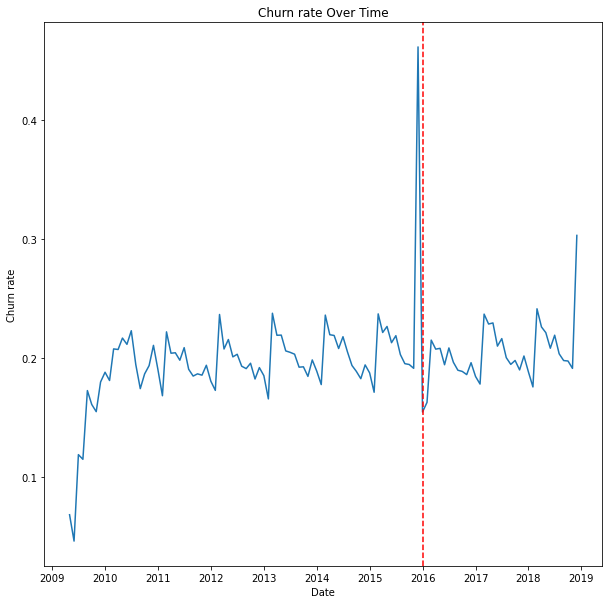

In [104]:
#Churn rate vs Time Graph
plt.figure(figsize=(10,10))
plt.plot(customers_total['Date'], customers_total['Churn'])
plt.title('Churn rate Over Time')
plt.ylabel('Churn rate')
plt.xlabel('Date')
plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
plt.show()

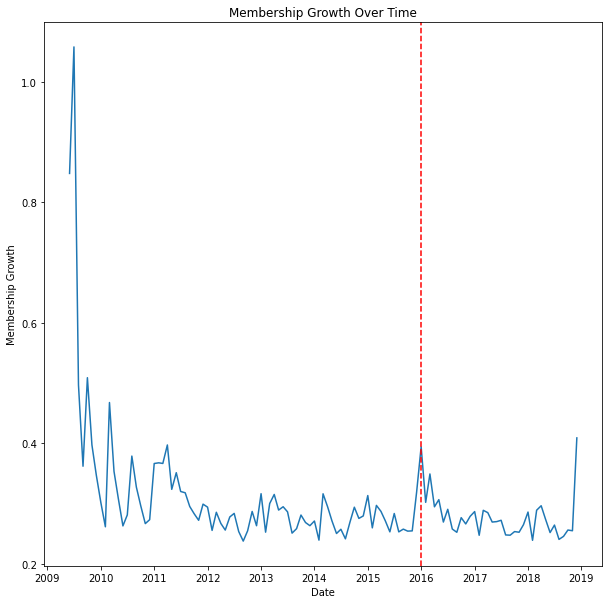

In [120]:
#Membership Growth vs Time Graph
plt.figure(figsize=(10,10))
plt.plot(customers_total['Date'], customers_total['Membership Growth'])
plt.title('Membership Growth Over Time')
plt.ylabel('Membership Growth')
plt.xlabel('Date')
plt.axvline(x=datetime.strptime('2016-01-01', '%Y-%m-%d'), linestyle='--', color = 'r')
plt.show()